In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.nddata import NDData
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import skycoord_to_pixel
from astropy.wcs import WCS, FITSFixedWarning
from astropy.nddata import Cutout2D
import astropy.units as uu
from astroquery.gaia import Gaia
from reproject import reproject_interp
from reproject.mosaicking import reproject_and_coadd
from grizli.utils import log_scale_ds9
from astropy.modeling import models, fitting
from scipy.ndimage import binary_fill_holes
Gaia.ROW_LIMIT = int(1e6)

def make_circular_mask(radius, imsize):
    im = np.zeros((imsize,imsize))
    yy,xx = np.mgrid[0:imsize,0:imsize]
    dd = (xx-imsize//2)**2. + (yy-imsize//2)**2.
    sel = np.where(dd < (radius*radius))
    im[sel] = 1
    return im

In [2]:
hdulist = fits.open("uma-03-ir_drc_sci.fits")
hdulistindex=0

# Get list of stars from astroquery

In [3]:
data = hdulist[hdulistindex].data
wcs = WCS(hdulist[hdulistindex].header)
(bottomleft, topleft, topright, bottomright) = wcs.calc_footprint()
bottomleft = SkyCoord(ra=bottomleft[0], dec=bottomleft[1], unit=(uu.degree, uu.degree), frame=hdulist[hdulistindex].header['RADESYS'].lower())
topright = SkyCoord(ra=topright[0], dec=topright[1], unit=(uu.degree, uu.degree), frame=hdulist[hdulistindex].header['RADESYS'].lower())
searchradius = bottomleft.separation(topright)
stars = Gaia.query_object(coordinate=bottomleft, radius=searchradius)
starscoord = SkyCoord(ra=stars['ra'], dec=stars['dec'], frame='icrs')
in_image_idx = wcs.footprint_contains(starscoord)
stars_in_image = stars[in_image_idx]
print(len(stars_in_image))
stars_in_image = stars_in_image[(stars_in_image['classprob_dsc_combmod_star']>0.5)]
starxp, staryp = skycoord_to_pixel(SkyCoord(ra=stars_in_image['ra'], dec=stars_in_image['dec'], frame='icrs'), wcs=wcs)

62


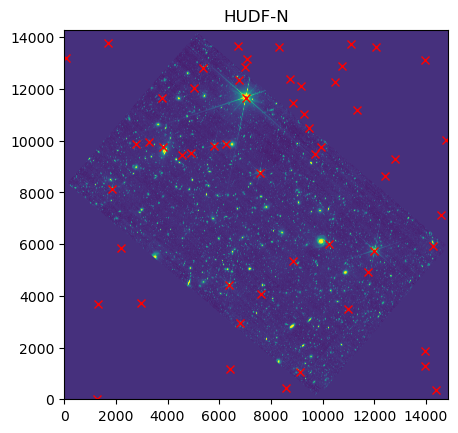

In [4]:
plt.figure()
plt.imshow(log_scale_ds9(data), origin='lower')
plt.plot(starxp, staryp, 'rx')
plt.title("HUDF-N")
plt.show()

# Make Cutouts and Size Measurements

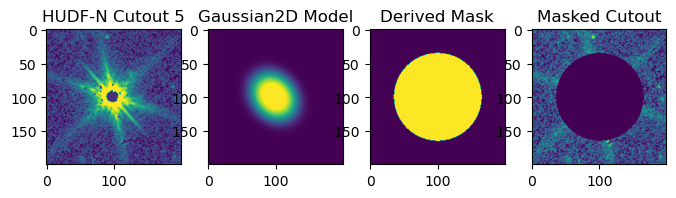

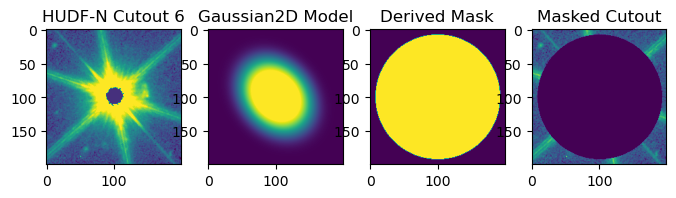

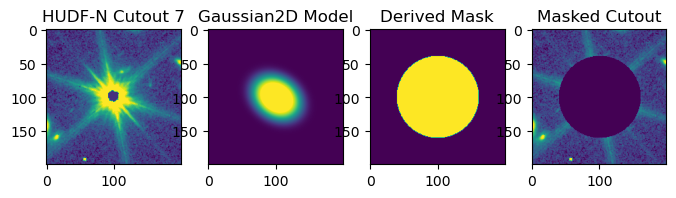

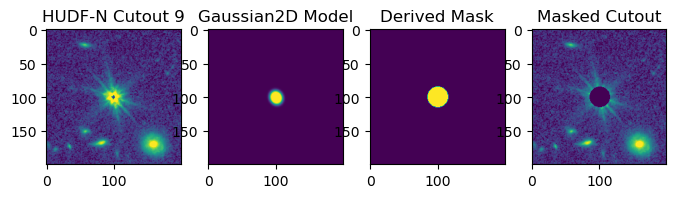

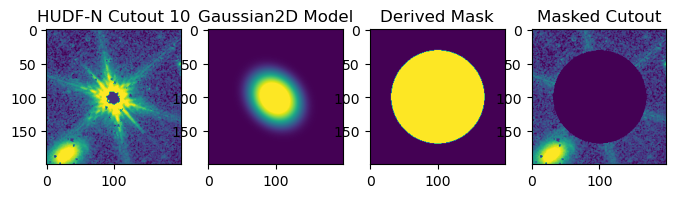

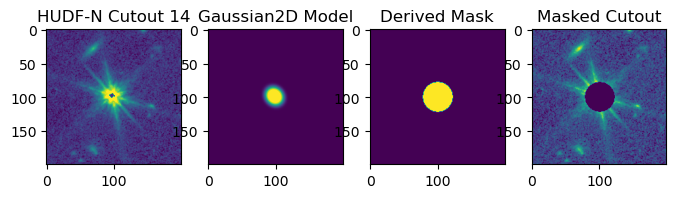

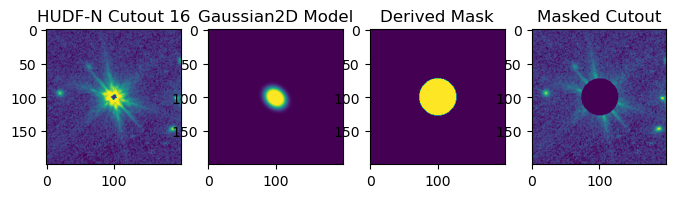

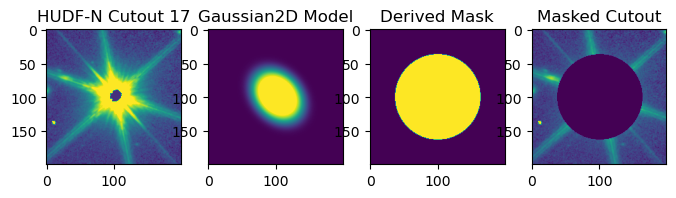

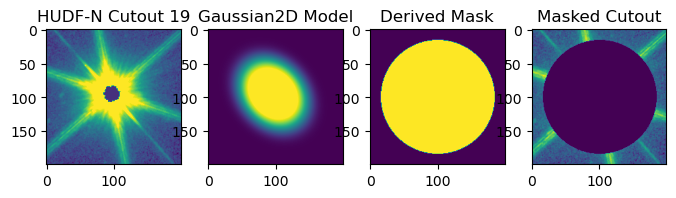

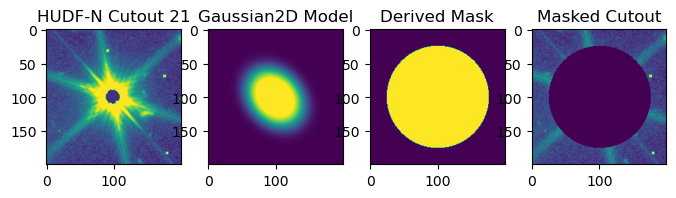

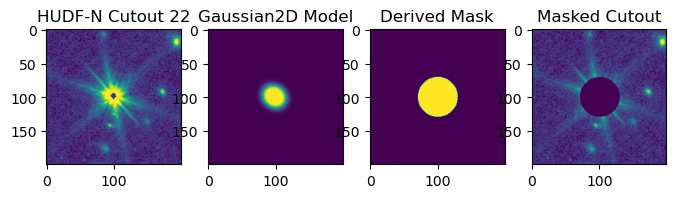

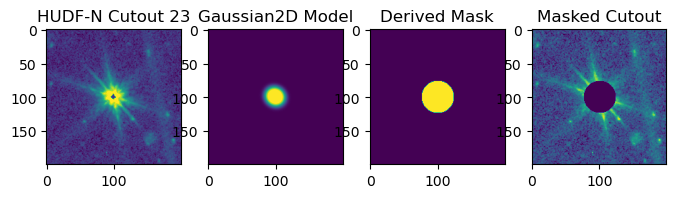

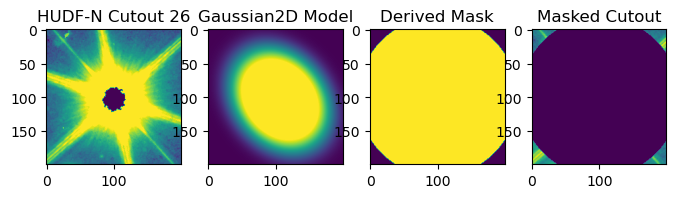

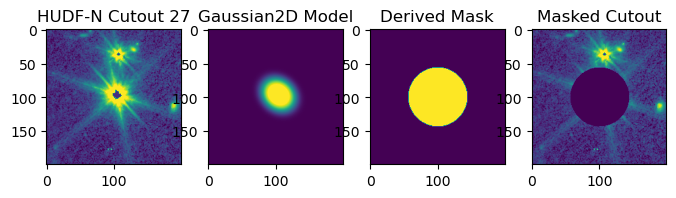

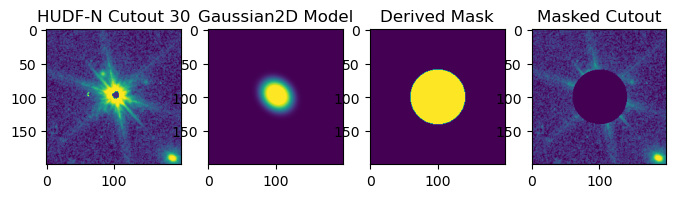

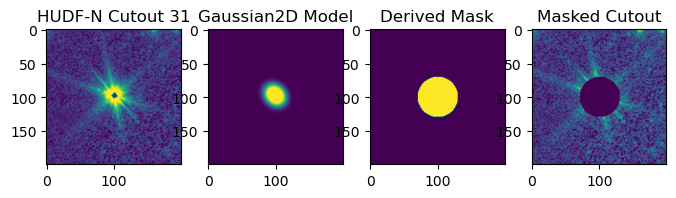

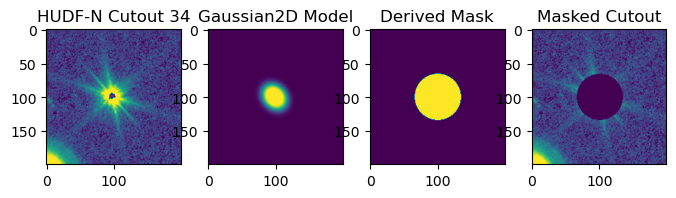

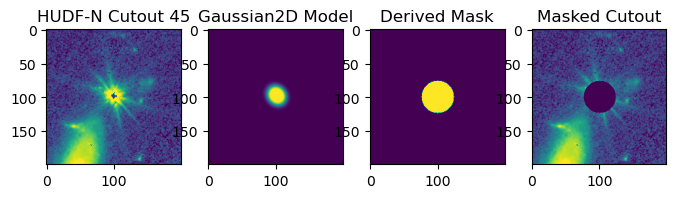

In [7]:
sz = 200
badfits = [11,12,13,15,18,20,24,28]
radiusvalues = []
magvalues = []
for ii in range(0,len(stars_in_image)):
    cutout = Cutout2D(data, position=(starxp[ii],staryp[ii]), size=(sz,sz))
    if np.sum((cutout.data>0))/len(cutout.data.flatten())>0.4:
        if ii not in badfits:
            cdata = cutout.data
            yy,xx = np.mgrid[0:cdata.shape[0], 0:cdata.shape[1]]
    
            p_init = models.Gaussian2D(amplitude=4*np.std(cdata), x_mean=sz/2, y_mean=sz/2, x_stddev=10, y_stddev=10)
            fit_p = fitting.LevMarLSQFitter()
            bestfitmodel = fit_p(p_init, xx, yy, cdata)
    
            maskradius = 4*np.max([bestfitmodel.x_stddev.value, bestfitmodel.y_stddev.value])
            mask = make_circular_mask(maskradius, sz)
            
            fig,axs=plt.subplots(ncols=4,figsize=(8,3))
            axs[0].imshow(log_scale_ds9(cdata))
            axs[0].set_title("HUDF-N Cutout %d" % ii)
            axs[1].imshow(log_scale_ds9(bestfitmodel(xx,yy)))
            axs[1].set_title("Gaussian2D Model")
            axs[2].imshow(mask)
            axs[2].set_title("Derived Mask")
            axs[3].imshow((1-mask)*log_scale_ds9(cdata))
            axs[3].set_title("Masked Cutout")
            plt.show()

            radiusvalues.append(maskradius)
            magvalues.append(stars_in_image['phot_g_mean_mag'][ii])

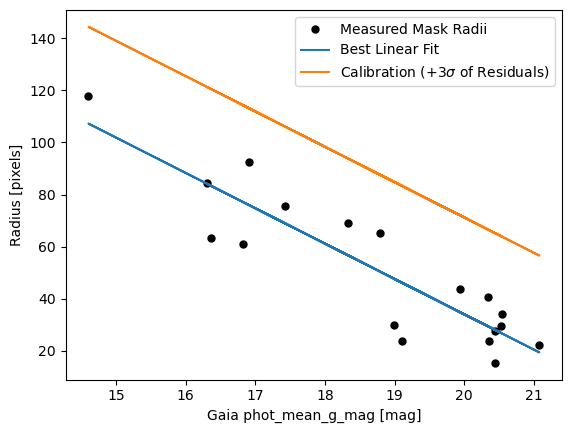

In [8]:
plt.figure()
plt.plot(magvalues, radiusvalues, 'k.', markersize=10, label='Measured Mask Radii')
popt = np.polyfit(magvalues, radiusvalues, 1)
fittedvalues = np.polyval(popt, magvalues)
plt.plot(magvalues, fittedvalues, label='Best Linear Fit')

residuals = (radiusvalues - fittedvalues)
dy = 3*np.std(residuals)
plt.plot(magvalues, np.polyval(popt, magvalues)+dy, label=r'Calibration (+3$\sigma$ of Residuals)')
plt.legend(loc='best')
plt.xlabel('Gaia phot_mean_g_mag [mag]')
plt.ylabel('Radius [pixels]')
plt.show()

In [9]:
print("calibration: slope %0.3f and intercept %0.3f" % (popt[0], popt[1]+dy))

calibration: slope -13.551 and intercept 342.216
